In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('v14.csv')

In [3]:
data

,Price,Demand,Supply
0,7.0,183,5
1,8.5,160,19
2,9.3,141,41
3,10.0,135,55
4,11.0,121,70
5,12.3,102,93
6,13.1,80,123
7,14.0,58,155
8,15.8,44,174
9,16.5,21,199


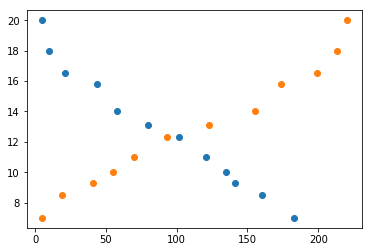

In [4]:
plt.plot(data['Demand'].values, data['Price'].values, 'o')
plt.plot(data['Supply'].values, data['Price'].values, 'o')
plt.show()

In [5]:
# Необхідні константи
p_dens = 200
data['Const'] = 1
min_pr, max_pr = data.iloc[0]['Price'], data.iloc[-1]['Price']
prices = np.linspace(min_pr, max_pr, p_dens)

## Знаходження аналітичного вигляду функція попиту та пропозиції
Функції попиту та пропозиції будемо знаходити у вигляді: 
\begin{align}
Q=\alpha f(P)+\beta
\end{align}
де $f$ задовольняє таким властивостям:
\begin{align}
\frac{\partial f}{\partial P} &< 0\ \ \ \ \frac{\partial^2 f}{\partial P^2} >= 0\ \ \ \ (для\ функції\ попиту) \\
\frac{\partial f}{\partial P} &> 0\ \ \ \ \frac{\partial^2 f}{\partial P^2} <= 0\ \ \ \ (для\ функції\ пропозиції) \\
\end{align}

Знайдемо значення $\alpha$ та $\beta$ за допомогою лінійної регресії з квадратичною функцією втрат. \\
Нехай дано вибірку $Q^*$, $P^*$. Тоді потрібно мінімізувати функціонал:
\begin{align}
L(P^*,Q^*)=(\alpha f(P^*)+\beta - Q^*)^T(\alpha f(P^*)+\beta - Q^*)
\end{align}
Тоді параметри набувають вигляду:
\begin{align}
(\alpha, \beta) &= (X^T X)^{-1} X^T Q^*\ ,де\\
X &= \begin{bmatrix}f(P^*_1) & 1\\f(P^*_2) & 1\\... & ... \\ f(P^*_n) & 1\end{bmatrix}\ ,де\ n\ -\ кількість\ елементів\ у\ вибірці
\end{align}
Модель лінійної регресії реалізований в класі sklearn.linear_model.LinearRegression.

# Апроксимація попиту

In [6]:
data['InvPrice'] = 1 / data['Price'].values

In [7]:
model_demand = LinearRegression()

model_demand.fit(data[['InvPrice', 'Const']].values, data['Demand'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
to_pred_dem = np.concatenate([1 / prices.reshape(-1, 1),
                          np.ones([p_dens]).reshape(-1, 1)], axis=1)
pred_dem = model_demand.predict(to_pred_dem)

In [9]:
def Q_d(P):
    P = 1 / np.reshape(P, (-1, 1))
    to_predict = np.concatenate([P, np.ones(P.shape)], axis=1)
    return model_demand.predict(to_predict)

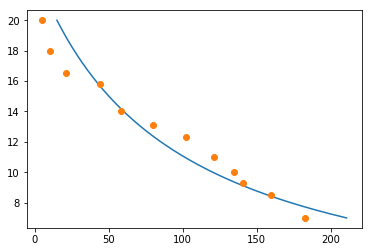

In [10]:
plt.plot(Q_d(prices), prices)
plt.plot(data['Demand'], data['Price'], 'o')
plt.show()

In [11]:
model_demand.coef_

array([ 2108.57405921,     0.        ])

In [12]:
print("Q = {}/P".format(round(model_demand.coef_[0], 2)))

Q = 2108.57/P


# Апроксимація попиту

In [13]:
data['LogPrice'] = np.log(data['Price'].values)

In [14]:
model_supply = LinearRegression()

model_supply.fit(data[['LogPrice', 'Const']], data['Supply'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
def Q_s(P):
    P = np.log(np.reshape(P, (-1, 1)))
    to_predict = np.concatenate([P, np.ones(P.shape)], axis=1)
    return model_supply.predict(to_predict)

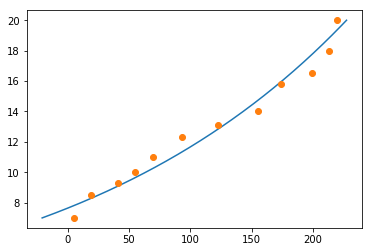

In [16]:
plt.plot(Q_s(prices), prices)
plt.plot(data['Supply'], data['Price'], 'o')
plt.show()

In [17]:
model_supply.coef_

array([ 236.45920832,    0.        ])

In [18]:
print("Q = {}*log(P)".format(round(model_supply.coef_[0], 2)))

Q = 236.46*log(P)


# Точка ринкової рівноваги

In [19]:
def intersection(f1, f2, values):
    ind = np.argmin(np.abs(f1(values) - f2(values)))
    return (values[ind], ((f1(values[ind]) + f2(values[ind])) / 2)[0])

In [20]:
balance_point = intersection(Q_d, Q_s, prices)

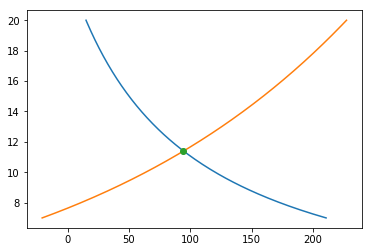

Точка ринкової рівноваги. P:11.0, Q:94.0


In [21]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(balance_point[1], balance_point[0], 'o')
plt.show()
print("Точка ринкової рівноваги. P:{}, Q:{}".format(round(balance_point[0]), round(balance_point[1])))

# Дугова еластичність

In [22]:
def arc_elasticity(f, values): # returns len(values) - 1 numbers
    v1, v2 = values[:-1], values[1:]
    f1, f2 = f(v1), f(v2)
    return (f2 - f1) / (v2 - v1) * (v2 + v1) / (f2 + f1)

### Попит

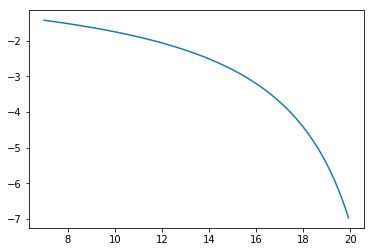

In [23]:
plt.plot(prices[:-1], arc_elasticity(Q_d, prices))
plt.show()

In [24]:
print("Попит {}є абсолютно еластичним".format("" if np.all(abs(arc_elasticity(Q_d, prices)) > 1) else "не "))

Попит є абсолютно еластичним


### Пропозиція

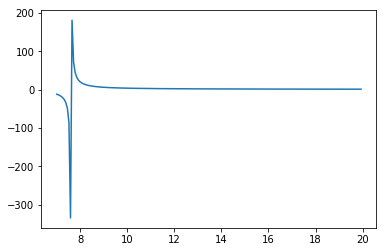

In [25]:
plt.plot(prices[:-1], arc_elasticity(Q_s, prices))
plt.show()

In [26]:
print("Пропозиція {}є абсолютно еластичною".format("" if np.all(abs(arc_elasticity(Q_s, prices)) > 1) else "не "))

Пропозиція є абсолютно еластичною


# Вплив держави на ціни
### Податок та субсидії на одну із сторін (споживач, виробник)

In [27]:
bal_tax_dem = bal_tax_sup = bal_tax_dem = bal_tax_sub = (-1, -1)

In [28]:
tax_dem = 5
tax_sup = 5
subsidy_dem = 5
subsidy_sup = 5

In [29]:
Q_d_tax = lambda p: Q_d(p + tax_dem)
Q_d_subsidy = lambda p,: Q_d(p - subsidy_dem)
Q_s_tax = lambda p: Q_s(p + tax_sup)
Q_s_subsidy = lambda p: Q_s(p - subsidy_sup)

In [30]:
bal_tax_dem = intersection(Q_d_tax, Q_s, prices)
bal_tax_sup = intersection(Q_d, Q_s_tax, prices)
bal_subsidy_dem = intersection(Q_d_subsidy, Q_s, prices)
bal_subsidy_sup = intersection(Q_d, Q_s_subsidy, prices)

In [31]:
bal_points1 = [bal_tax_dem, bal_subsidy_sup, bal_tax_sup, bal_subsidy_dem]

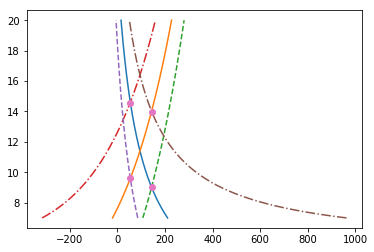

Точка ринкової рівноваги при податку зі сторони споживача 5. P:10.0, Q:54.0
Точка ринкової рівноваги при податку зі сторони виробника 5. P:9.0, Q:143.0
Точка ринкової рівноваги при субсидіях зі сторони споживача 5. P:14.0, Q:144.0
Точка ринкової рівноваги при субсидіях зі сторони виробника 5. P:15.0, Q:54.0


In [32]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(Q_s_tax(prices), prices, '--')
plt.plot(Q_s_subsidy(prices), prices, '-.')
plt.plot(Q_d_tax(prices), prices, '--')
plt.plot(Q_d_subsidy(prices), prices, '-.')
plt.plot([p[1] for p in bal_points1], [p[0] for p in bal_points1], 'o')
plt.show()
print("Точка ринкової рівноваги при податку зі сторони споживача {}. P:{}, Q:{}".format(tax_dem, round(bal_tax_dem[0]), round(bal_tax_dem[1])))
print("Точка ринкової рівноваги при податку зі сторони виробника {}. P:{}, Q:{}".format(tax_sup, round(bal_tax_sup[0]), round(bal_tax_sup[1])))
print("Точка ринкової рівноваги при субсидіях зі сторони споживача {}. P:{}, Q:{}".format(subsidy_dem, round(bal_subsidy_dem[0]), round(bal_subsidy_dem[1])))
print("Точка ринкової рівноваги при субсидіях зі сторони виробника {}. P:{}, Q:{}".format(subsidy_sup, round(bal_subsidy_sup[0]), round(bal_subsidy_sup[1])))

### Еквівалентний податок та субсидії

In [33]:
eq_tax = 2.5
eq_subsidy = 2.5

In [34]:
Q_d_eq_tax = lambda P: Q_d(P + eq_tax)
Q_d_eq_subsidy = lambda P: Q_d(P - eq_subsidy)
Q_s_eq_tax = lambda P: Q_s(P - eq_tax)
Q_s_eq_subsidy = lambda P: Q_s(P - eq_subsidy)

In [35]:
bal_eq_tax = intersection(Q_d_eq_tax, Q_s_eq_tax, prices)
bal_eq_subsidy = intersection(Q_d_eq_subsidy, Q_s_eq_subsidy, prices)

In [36]:
bal_points2 = [bal_eq_tax, bal_eq_subsidy]

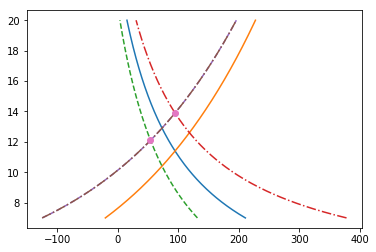

Точка ринкової рівноваги при еквівалентному податку 2.5. P:12.0, Q:54.0
Точка ринкової рівноваги при еквівалентних субсидіях 2.5. P:14.0, Q:95.0


In [37]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(Q_d_eq_tax(prices), prices, '--')
plt.plot(Q_d_eq_subsidy(prices), prices, '-.')
plt.plot(Q_s_eq_tax(prices), prices, '--')
plt.plot(Q_s_eq_subsidy(prices), prices, '-.')
plt.plot([p[1] for p in bal_points2], [p[0] for p in bal_points2], 'o')
plt.show()
print("Точка ринкової рівноваги при еквівалентному податку {}. P:{}, Q:{}".format(eq_tax, round(bal_eq_tax[0]), round(bal_eq_tax[1])))
print("Точка ринкової рівноваги при еквівалентних субсидіях {}. P:{}, Q:{}".format(eq_tax, round(bal_eq_subsidy[0]), round(bal_eq_subsidy[1])))

### Квота

In [38]:
quote = 70

In [39]:
def Q_s_quote(P):
    Q = Q_s(P)
    Q[Q > quote] = quote
    return Q

In [40]:
bal_quote = intersection(Q_d, Q_s_quote, prices)

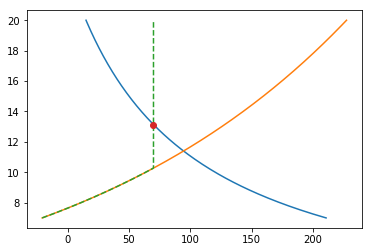

Точка ринкової рівноваги при квоті 70. P:13.1, Q:70.0


In [41]:
plt.plot(Q_d(prices), prices)
plt.plot(Q_s(prices), prices)
plt.plot(Q_s_quote(prices), prices, '--')
plt.plot(bal_quote[1], bal_quote[0], 'o')
plt.show()
print("Точка ринкової рівноваги при квоті {}. P:{}, Q:{}".format(quote, round(bal_quote[0], 1), round(bal_quote[1], 1)))